<a href="https://colab.research.google.com/github/as791/Adversarial-Example-Attack-and-Defense/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [9]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [10]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.2743309789251537 Val_Loss: 0.14043042105083334
Epoch: 2 Loss: 0.10781129588465978 Val_Loss: 0.10459050073224621
Epoch: 3 Loss: 0.08269814029661202 Val_Loss: 0.09366282671471401
Epoch: 4 Loss: 0.07234353831489537 Val_Loss: 0.0902839079435505
Epoch: 5 Loss: 0.07009020421660436 Val_Loss: 0.08765654317761855
Epoch: 6 Loss: 0.06189817700303269 Val_Loss: 0.08645812251728655
Epoch: 7 Loss: 0.060205166572401866 Val_Loss: 0.08193998605651531
Epoch: 8 Loss: 0.05781161014309188 Val_Loss: 0.09551908857568245
Epoch: 9 Loss: 0.0556511076812988 Val_Loss: 0.08640749814592191
Epoch: 10 Loss: 0.054742545022463736 Val_Loss: 0.08181153080971278


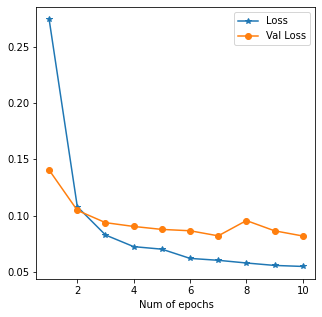

In [11]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [19]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [20]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.007	Test Accuracy = 9688 / 10000 = 0.9688
Epsilon: 0.01	Test Accuracy = 9690 / 10000 = 0.969
Epsilon: 0.02	Test Accuracy = 9627 / 10000 = 0.9627
Epsilon: 0.03	Test Accuracy = 9553 / 10000 = 0.9553
Epsilon: 0.05	Test Accuracy = 9342 / 10000 = 0.9342
Epsilon: 0.1	Test Accuracy = 8494 / 10000 = 0.8494
Epsilon: 0.2	Test Accuracy = 5050 / 10000 = 0.505
Epsilon: 0.3	Test Accuracy = 2549 / 10000 = 0.2549


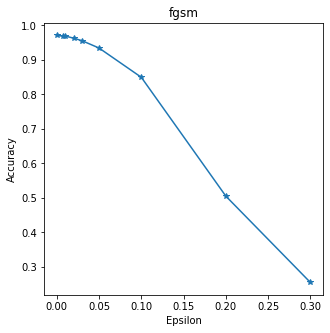

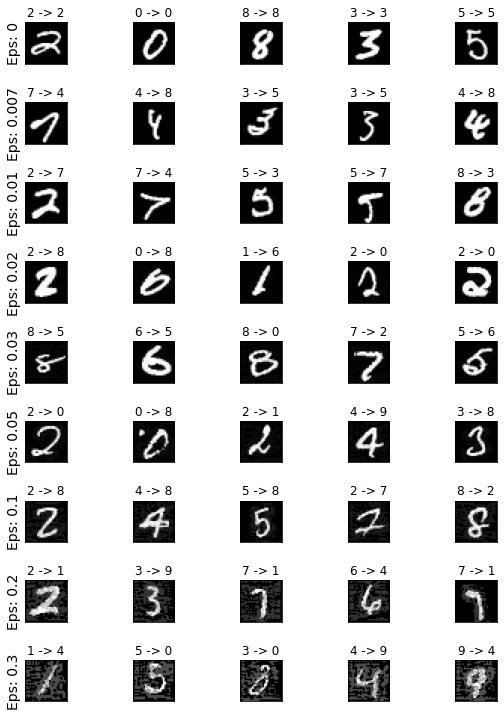

Epsilon: 0	Test Accuracy = 9727 / 10000 = 0.9727
Epsilon: 0.007	Test Accuracy = 9698 / 10000 = 0.9698
Epsilon: 0.01	Test Accuracy = 9669 / 10000 = 0.9669
Epsilon: 0.02	Test Accuracy = 9612 / 10000 = 0.9612
Epsilon: 0.03	Test Accuracy = 9561 / 10000 = 0.9561
Epsilon: 0.05	Test Accuracy = 9437 / 10000 = 0.9437
Epsilon: 0.1	Test Accuracy = 8706 / 10000 = 0.8706
Epsilon: 0.2	Test Accuracy = 5836 / 10000 = 0.5836
Epsilon: 0.3	Test Accuracy = 2932 / 10000 = 0.2932


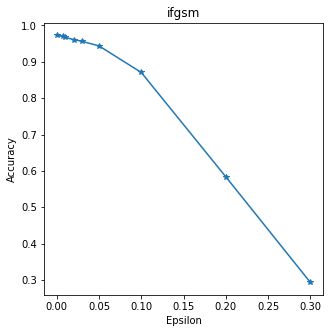

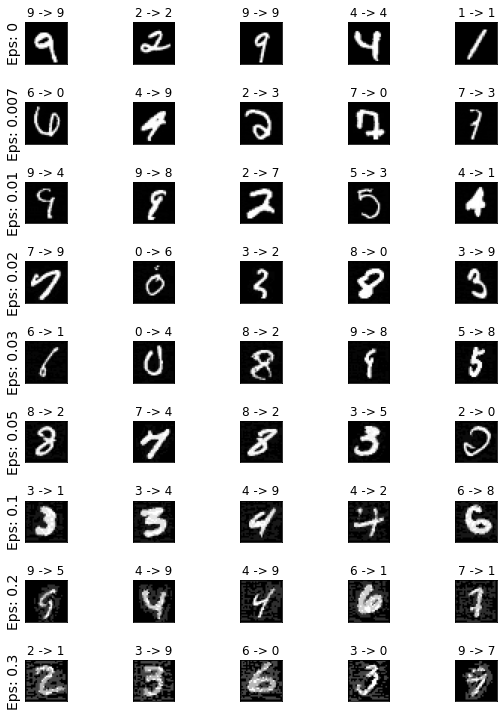

Epsilon: 0	Test Accuracy = 9727 / 10000 = 0.9727
Epsilon: 0.007	Test Accuracy = 9686 / 10000 = 0.9686
Epsilon: 0.01	Test Accuracy = 9684 / 10000 = 0.9684
Epsilon: 0.02	Test Accuracy = 9649 / 10000 = 0.9649
Epsilon: 0.03	Test Accuracy = 9568 / 10000 = 0.9568
Epsilon: 0.05	Test Accuracy = 9397 / 10000 = 0.9397
Epsilon: 0.1	Test Accuracy = 8780 / 10000 = 0.878
Epsilon: 0.2	Test Accuracy = 5805 / 10000 = 0.5805
Epsilon: 0.3	Test Accuracy = 3006 / 10000 = 0.3006


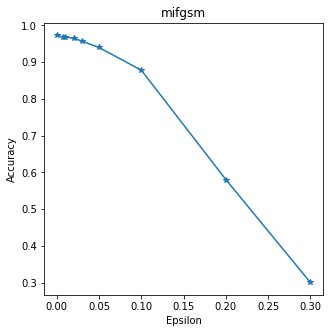

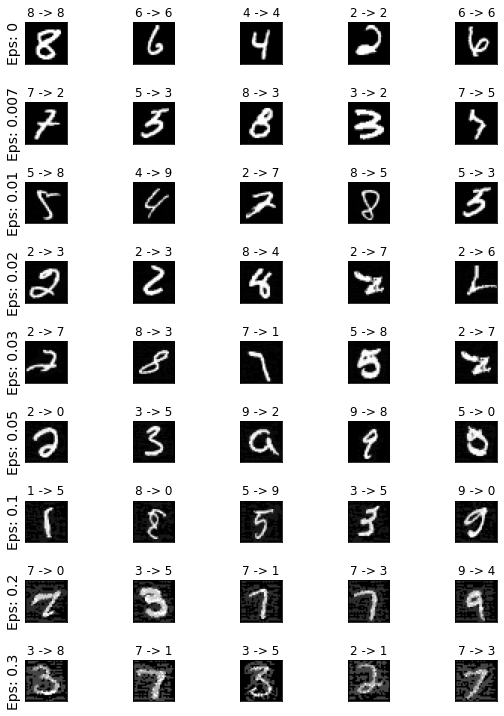

In [21]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

##Defense

In [22]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [23]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [24]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1] 
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [30]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = modelF(input)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5113981436585816 Val_Loss: 0.3674813140166035
Epoch: 2 Loss: 0.31989784196061316 Val_Loss: 0.29424746949264335
Epoch: 3 Loss: 0.2515257266181656 Val_Loss: 0.23545903766988213
Epoch: 4 Loss: 0.1960982317868901 Val_Loss: 0.19550847488101594
Epoch: 5 Loss: 0.16181091205252418 Val_Loss: 0.16023132022311593
Epoch: 6 Loss: 0.13417453448640274 Val_Loss: 0.1403275839784423
Epoch: 7 Loss: 0.1187279349627575 Val_Loss: 0.13027063180142387
Epoch: 8 Loss: 0.10641808225778623 Val_Loss: 0.11304506835860761
Epoch: 9 Loss: 0.10068741528489435 Val_Loss: 0.11180556543545608
Epoch: 10 Loss: 0.09318216142965721 Val_Loss: 0.1134776860654315


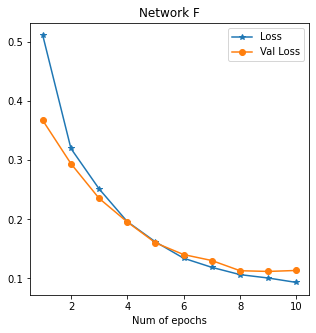

Fitting the model...
Epoch: 1 Loss: 0.696845066422859 Val_Loss: 0.5063352049666082
Epoch: 2 Loss: 0.4786464158107763 Val_Loss: 0.4589710831519903
Epoch: 3 Loss: 0.43736858573977405 Val_Loss: 0.4456053978943798
Epoch: 4 Loss: 0.41016261236171 Val_Loss: 0.412141632687185
Epoch: 5 Loss: 0.38460293393910294 Val_Loss: 0.402892213285434
Epoch: 6 Loss: 0.36175844994660006 Val_Loss: 0.36564972530566553
Epoch: 7 Loss: 0.3329635148455422 Val_Loss: 0.3371666255949156
Epoch: 8 Loss: 0.2885666255653116 Val_Loss: 0.28247964478716786
Epoch: 9 Loss: 0.24975738619624854 Val_Loss: 0.24752651050095578
Epoch: 10 Loss: 0.22040875698636203 Val_Loss: 0.2242643935349514


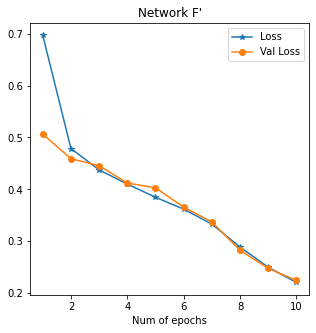

Epsilon: 0	Test Accuracy = 9164 / 10000 = 0.9164
Epsilon: 0.007	Test Accuracy = 9095 / 10000 = 0.9095
Epsilon: 0.01	Test Accuracy = 9142 / 10000 = 0.9142
Epsilon: 0.02	Test Accuracy = 9073 / 10000 = 0.9073
Epsilon: 0.03	Test Accuracy = 9110 / 10000 = 0.911
Epsilon: 0.05	Test Accuracy = 9082 / 10000 = 0.9082
Epsilon: 0.1	Test Accuracy = 9042 / 10000 = 0.9042
Epsilon: 0.2	Test Accuracy = 9006 / 10000 = 0.9006
Epsilon: 0.3	Test Accuracy = 8955 / 10000 = 0.8955


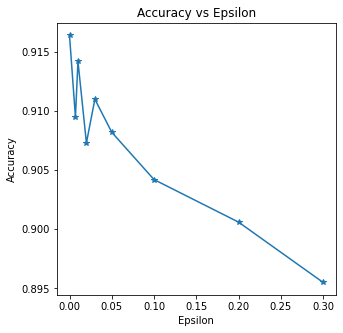

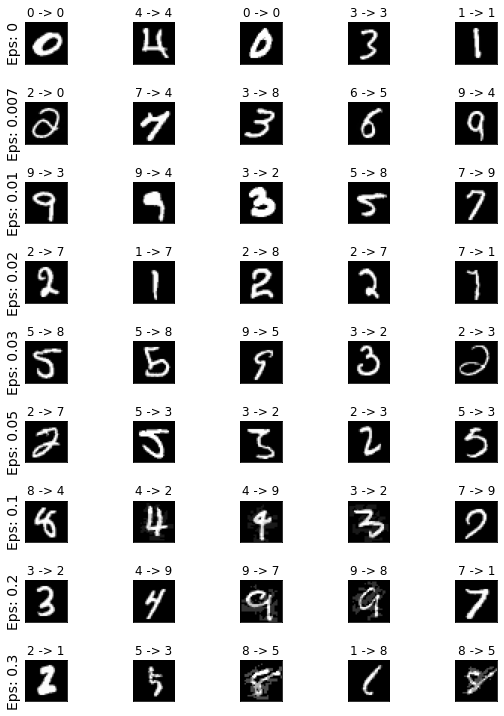

Epsilon: 0	Test Accuracy = 9124 / 10000 = 0.9124
Epsilon: 0.007	Test Accuracy = 9131 / 10000 = 0.9131
Epsilon: 0.01	Test Accuracy = 9118 / 10000 = 0.9118
Epsilon: 0.02	Test Accuracy = 9095 / 10000 = 0.9095
Epsilon: 0.03	Test Accuracy = 9110 / 10000 = 0.911
Epsilon: 0.05	Test Accuracy = 9058 / 10000 = 0.9058
Epsilon: 0.1	Test Accuracy = 9049 / 10000 = 0.9049
Epsilon: 0.2	Test Accuracy = 9016 / 10000 = 0.9016
Epsilon: 0.3	Test Accuracy = 8967 / 10000 = 0.8967


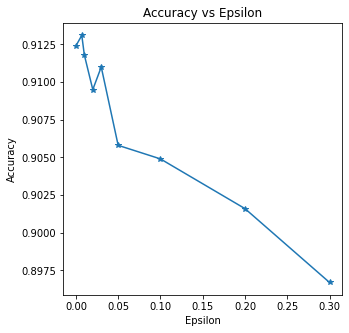

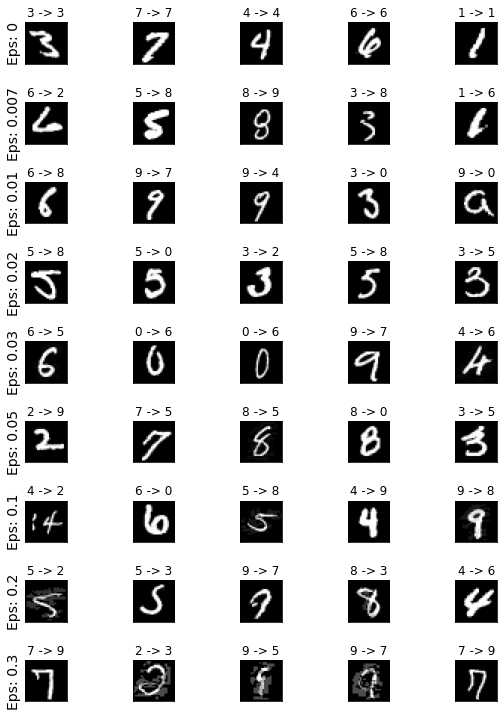

Epsilon: 0	Test Accuracy = 9131 / 10000 = 0.9131
Epsilon: 0.007	Test Accuracy = 9139 / 10000 = 0.9139
Epsilon: 0.01	Test Accuracy = 9096 / 10000 = 0.9096
Epsilon: 0.02	Test Accuracy = 9118 / 10000 = 0.9118
Epsilon: 0.03	Test Accuracy = 9106 / 10000 = 0.9106
Epsilon: 0.05	Test Accuracy = 9109 / 10000 = 0.9109
Epsilon: 0.1	Test Accuracy = 9091 / 10000 = 0.9091
Epsilon: 0.2	Test Accuracy = 8962 / 10000 = 0.8962
Epsilon: 0.3	Test Accuracy = 8903 / 10000 = 0.8903


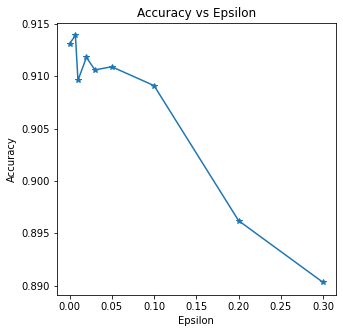

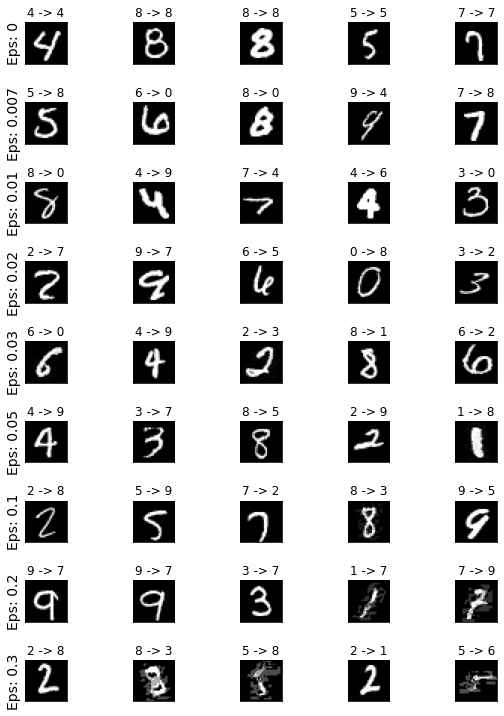

In [31]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)